(c) 2024 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import project package
import ActiveInference as AI

# Import basic math
import StatsBase
import Distributions
import Random

# Load plotting-related packages
using CairoMakie
import ColorSchemes
import Colors

# Activate backend
CairoMakie.activate!()

# Set Plotting style
AI.viz.theme_makie!()

# Brownian Motion

In this notebook we will explore the concept of Brownian motion, which is a
stochastic process---a random variable that evolves over time.

Brownian motion is a continuous-time stochastic process that models the random
motion of particles suspended in a fluid. It is named after the botanist Robert
Brown, who first described it in 1827. Brownian motion is a fundamental concept
in physics, chemistry, and biology, and it has applications in fields such as
finance, economics, and even linguistics.

To formalize our understanding, let's begin by formally defining Brownian
motion.

## Definition of Brownian Motion

A stochastic process $W(t)$ for $t \in [0, T]$ is called **Brownian motion** or
**Standard Weinder Process** for the time range $[0, T]$ if it satisfies the
following conditions:

**C1. (Fixed Initial Condition)** 

Brownian motion satisfies
$$
W(0) = 0
\tag{1}
$$
**C2. (Stationary Increments)** 

For $0 \leq s < t \leq T, the random variable increment
$$
W(t) - W(s) \sim \mathcal{N}(0, t-s),
\tag{2}
$$
or, equivalently,
$$
W(t) - W(s) \sim \sqrt{t-s} \mathcal{N}(0, 1).
\tag{3}
$$
**C3. (Independent Increments)** 

For $0 \leq s \leq t \leq u \leq v \leq T$, the increments $W(t) - W(s)$ and
$W(v) - W(u)$ are independent.

## Discretizing Brownian Motion

Although a Brownian motion is a continuous-time stochastic process, for computer
simulations it is useful to discretize it. We let
$$
\delta t = \frac{T}{L},
\tag{4}
$$
be the length of each time step, for some positive integer $L$. We then let
$$
W_i = W(t_i), \quad t_i = i \delta t, \quad i = 0, 1, \ldots, L-1,
\tag{5}
$$
be the value of the Brownian motion at each time step.

**C1.** sets $W_0 = 0$, while **C2.** and **C3.** together imply that
$$
W_{i+1} = W_i + \delta W_i,
\tag{6}
$$
where
$$
\delta W_i \sim \sqrt{\delta t} \mathcal{N}(0, 1).
\tag{7}
$$

This simple update rule---adding an independent Gaussian-distributed random
variable to the current value---is the basis of how we will simulate Brownian
motion.

### Simulating simple Brownian motion

Let's simulate simple Brownian motion using the update rule in (6). To do this,
we will generate $L$ independent Gaussian random variables, multiply each by
$\sqrt{\delta t}$, and then cumulatively sum them to produce the Brownian
motion path.

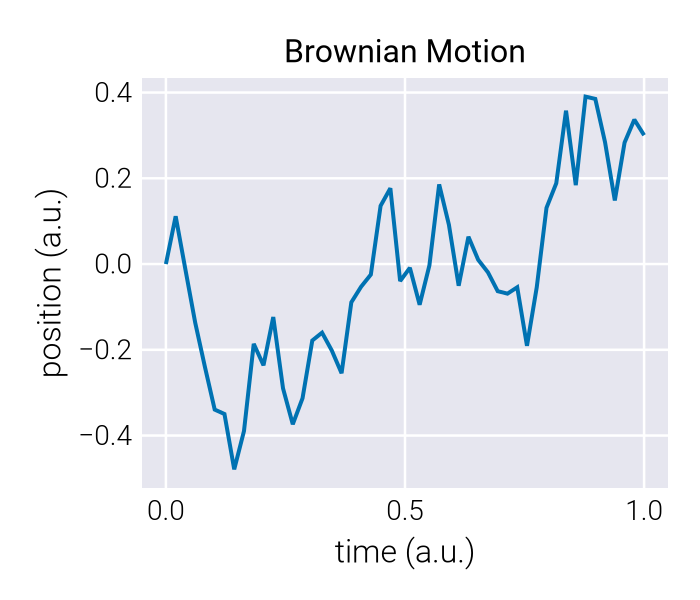

In [20]:
Random.seed!(42)
# Define the time points where to evaluate the Brownian motion
L = 50
T = 1.0
δt = T / L
# Define time vector
t = LinRange(0, T, L)

# Initialize the Brownian motion vector
W = Vector{Float64}(undef, L)
# Set the initial condition
W[1] = 0.0

# Simulate the Brownian motion
for i in 2:L
    W[i] = W[i-1] + randn() * sqrt(δt)
end

# Initialize the figure
fig = Figure(size=(350, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    title="Brownian Motion",
    xlabel="time (a.u.)",
    ylabel="position (a.u.)",
)

# Plot the Brownian motion
lines!(ax, t, W, label="Brownian Motion")

fig

We can easily extend this to multiple paths by simply repeating the simulation
for different initial conditions.

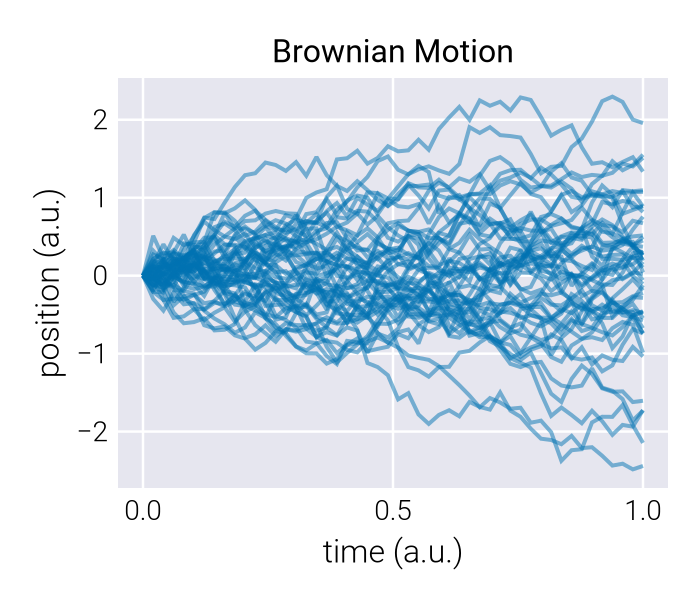

In [21]:
Random.seed!(42)

# Define the number of paths to simulate
n_paths = 50

# Initialize the Brownian motion matrix
W = Matrix{Float64}(undef, L, n_paths)
# Set the initial condition for all paths
W[:, 1] .= 0.0

# Simulate the Brownian motion for each path
for i in 2:L
    W[i, :] = W[i-1, :] + randn(n_paths) * sqrt(δt)
end # for

# Initialize the figure
fig = Figure(size=(350, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    title="Brownian Motion",
    xlabel="time (a.u.)",
    ylabel="position (a.u.)",
)

# Plot the Brownian motion
series!(ax, t, W', solid_color=(ColorSchemes.seaborn_colorblind[1], 0.5))

fig

## Filling in a Brownian path

In some circumstances, we compute a discretized Brownian path $\{t_i,
W_i\}_{i=0}^L$ and want to refine the discretization; that is we want to compute
values of the path at one or more times in between each $t_i$.

One can show that the correct way to satisfy all of the conditions of Brownian
motion is to use the Brownian bridge process. Computationally, this process
implies that
$$
W_{i+1/2} = \frac{1}{2} \left( W_i + W_{i+1} \right) + 
\frac{1}{2} \sqrt{\delta t}\;\xi_i, \quad \xi_i \sim \mathcal{N}(0, 1)
\tag{8}
$$
Let's look at how this works in practice.

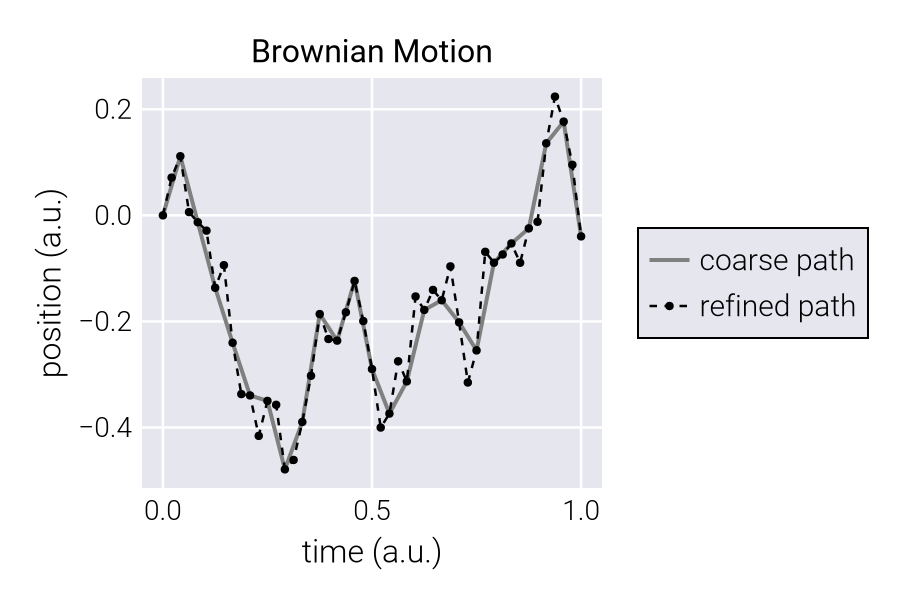

In [38]:
Random.seed!(42)
# Define number of steps in initial path
L_coarse = 25
# Define time vector for initial path
t_coarse = LinRange(0, T, L_coarse)
# Set initial coarse path
W_coarse = Vector{Float64}(undef, L_coarse)
W_coarse[1] = 0.0
for i in 2:L_coarse
    W_coarse[i] = W_coarse[i-1] + randn() * sqrt(δt)
end

# Define number of steps in new path
L_fine = 2 * L_coarse - 1
# Define time vector for new path
t_fine = LinRange(0, T, L_fine)
# Compute the new path
W_fine = Vector{Float64}(undef, L_fine)
# Set points from original path
W_fine[1:2:end] = W_coarse
# Loop over the new points
for i in 2:2:length(W_fine)
    # Set the midpoint
    W_fine[i] = 0.5 * (W_fine[i-1] + W_fine[i+1]) + 0.5 * randn() * sqrt(δt)
end

# Initialize the figure
fig = Figure(size=(450, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    title="Brownian Motion",
    xlabel="time (a.u.)",
    ylabel="position (a.u.)",
)

# Plot coarse path
lines!(
    ax,
    t_coarse,
    W_coarse,
    label="coarse path",
    color=:gray
)
# Plot new path
scatterlines!(
    ax,
    t_fine,
    W_fine,
    label="refined path",
    color=:black,
    linestyle=:dash,
    markersize=6
)

# Add legend
Legend(fig[1, 2], ax)

fig

## A Scaling Property of Brownian Motion

There is a remarkable scaling property of Brownian motion trajectories that is
worth highlighting. Let $W(t)$ be a Brownian motion trajectory over $[0, T]$,
then, for any fixed $c > 0$, we define
$$
V(t) = \frac{1}{c} W(c^2 t), 
\tag{9}
$$
Then, $V(t)$ is a Brownian motion trajectory over the time range $[0, c^2 T]$.
One can show that this process satisfies all conditions of Brownian motion.

What this means in practice is that we can "stretch" or "compress" Brownian
motion trajectories by simply rescaling the time variable and it will look
like Brownian motion. Thus, Brownian motion has a fractal-like self-similarity
to it.  Let's look at this in practice.